In [13]:
# Reading Data
import json

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

# Model
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Evaluation Metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Part 3
nltk.download('vader_lexicon')
import pytz
import datetime
from datetime import timedelta

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/guestcs/nltk_data...


In [2]:
def getJsonObjects(filename):
    json_list = list()
    with open(file_direct + filename, "r") as jsonfile:
        line = jsonfile.readline()
        while line:
            json_list.append(json.loads(line))
            line = jsonfile.readline()
        return json_list

In [3]:
file_direct = ""
json_list = getJsonObjects("updatedQ2_tweets_#superbowl.txt")
print(len(json_list))

1213813


In [4]:
print(json_list[0])

{'text': 'At http://t.co/Vd0RWOeAed -- #Seahawks #12thMAN #12 #SeahawkNation #SuperBowlBound #Superbowl #Repeat #GoHawks ... http://t.co/XSEFUKqEhN', 'location': '', 'citation_date': 1421468497}


In [5]:
def selectLocation(location):
    if ('Washington' in location or 'WA' in location or 'Seattle' in location or 'Kirkland' in location) and ("DC" not in location) and ("D.C." not in location):
        return 1
    elif 'Massachusetts' in location or ' MA' in location or 'Boston' in location:
        return -1
    return 0

In [6]:
# Only keep lines from MA and WA
json_list = [line for line in json_list if selectLocation(line['location']) != 0]
print(len(json_list))

38124


In [7]:
text_list = list()
location_list = list()
time_list = list()
for line in json_list:
    text_list.append(line['text'])
    location_list.append(selectLocation(line['location']))
    time_list.append(line['citation_date'])

In [51]:
def trim(text_list):
    for i in range(len(text_list)):
        text_list[i] = text_list[i].replace(".","")
        text_list[i] = text_list[i].replace(",","")
        text_list[i] = text_list[i].replace("?","")
        text_list[i] = text_list[i].replace("!","")
        text_list[i] = text_list[i].replace("#","")
        temp = text_list[i].split(" ")
        text_list[i] = " ".join([word for word in temp if (word.isalnum() and not word.isdigit())])
#         temp = re.findall('[a-zA-Z]+', text_list[i])
#         text_list[i] = " ".join(temp)
    return text_list

print(text_list[0])
count_vect = CountVectorizer(stop_words='english')
tfidf_transformer = TfidfTransformer()
trim(text_list)
print(text_list[0])
text_list_counts = count_vect.fit_transform(text_list)
text_list_tf_idf = tfidf_transformer.fit_transform(text_list_counts)
text_list_tf_idf.shape
X_train, X_test, y_train, y_test = train_test_split(text_list_tf_idf, location_list, train_size=0.9, random_state=42)

Our @ButchStearns talked #Patriots w/3X #SuperBowl champ Matt Light Full interview @ 10 http://t.co/6s9XqUUcyj #FOX25 http://t.co/iTAFnwQc2G
Our talked Patriots SuperBowl champ Matt Light Full interview FOX25


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [52]:
svd = TruncatedSVD(n_components=100, random_state=0)
LSI_train_reduced = svd.fit_transform(X_train)
## Test
LSI_test_reduced = svd.transform(X_test)
print("LSI train shape: ", LSI_train_reduced.shape)
print("LSI test shape: ", LSI_test_reduced.shape)

LSI train shape:  (34311, 100)
LSI test shape:  (3813, 100)


In [53]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)

def confusionMatrixAndMetrics(ground_truth, predicts):
    conf_matrix = confusion_matrix(ground_truth, predicts)
    preci = precision_score(ground_truth, predicts)
    recall = recall_score(ground_truth, predicts)
    accur = accuracy_score(ground_truth, predicts)
    F1 = 2 / (1/recall + 1/preci)
    print("accuracy: ", accur)
    print("precision: ", preci)
    print("recall: ", recall)
    print("F1 score: ", F1)
    print ("confusion matrix: \n", conf_matrix)

accuracy:  0.7416732231838448
precision:  0.94655704008222
recall:  0.4967637540453074
F1 score:  0.6515741068270251
confusion matrix: 
 [[1907   52]
 [ 933  921]]


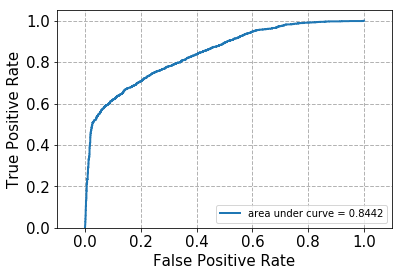

In [54]:
svm_model = LinearSVC(loss='hinge', C=0.025)
fit_predict_and_plot_roc(svm_model, LSI_train_reduced, y_train, LSI_test_reduced, y_test)
predicts = svm_model.fit(LSI_train_reduced, y_train).predict(LSI_test_reduced)
confusionMatrixAndMetrics(y_test, predicts)

accuracy:  0.7684238132703908
precision:  0.8963265306122449
recall:  0.5922330097087378
F1 score:  0.7132185774602143
confusion matrix: 
 [[1832  127]
 [ 756 1098]]


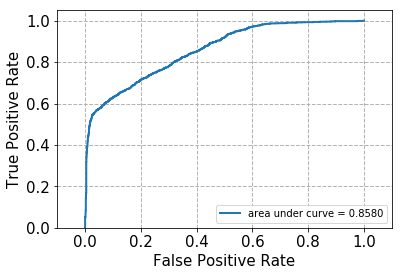

In [55]:
logreg = LogisticRegression(penalty = "l2", C = 10)
fit_predict_and_plot_roc(logreg, LSI_train_reduced , y_train, LSI_test_reduced, y_test)
predicts = logreg.fit(LSI_train_reduced, y_train).predict(LSI_test_reduced)
confusionMatrixAndMetrics(y_test, predicts)

accuracy:  0.7060057697351168
precision:  0.7631012203876526
recall:  0.5733549083063646
F1 score:  0.6547582383738836
confusion matrix: 
 [[1629  330]
 [ 791 1063]]


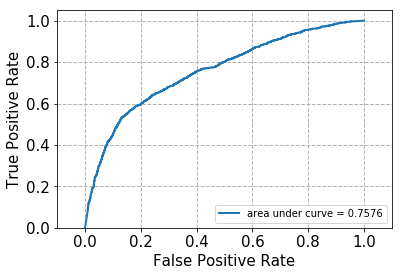

In [56]:
GNB = GaussianNB()
fit_predict_and_plot_roc(GNB, LSI_train_reduced, y_train, LSI_test_reduced, y_test)
predicts = GNB.fit(LSI_train_reduced, y_train).predict(LSI_test_reduced)
confusionMatrixAndMetrics(y_test, predicts)

In [14]:
print(set(location_list))

{1, -1}


In [8]:
def separateLocation(json_list):
    WA_list = list()
    MA_list = list()
    for line in json_list:
        if selectLocation(line['location']) == 1:
            WA_list.append(line)
        else:
            MA_list.append(line)
    return WA_list, MA_list

In [9]:
WA_list, MA_list = separateLocation(json_list)
print(len(WA_list), len(MA_list))

18337 19787


In [40]:
def creationTimeToMinute(unix_time, time_zone = pytz.timezone('America/Los_Angeles')):
    date_object = datetime.datetime.fromtimestamp(unix_time, time_zone)
    date_object = date_object.replace(second=0, microsecond=0)
    return date_object

def getHours(min_time = datetime.datetime(2015, 2, 1, 8, 0), max_time = datetime.datetime(2015, 2, 1, 20, 0)):
    # Description:
    # Get the the number of tweets, also features forom the tweet
    hr2cnt = dict()
    time_zone = pytz.timezone('America/Los_Angeles')
    min_time = time_zone.localize(min_time)
    max_time = time_zone.localize(max_time)
    hour_time = min_time + timedelta(minutes=10)
#     print(hour_time.timestamp())
    while hour_time <= max_time:
        hr2cnt[hour_time] = 0
        hour_time = hour_time + timedelta(minutes=10)
    return hr2cnt

hr2cnt = getHours()
print(len(hr2cnt))

72


In [41]:
def getStat(json_objects, hr2cnt):
    # Description:
    # Get the the number of tweets, also features forom the tweet
    sid = SentimentIntensityAnalyzer()
    sent_list = [[] for time in hr2cnt.keys()]
    time_zone = pytz.timezone('America/Los_Angeles')
    json_objects.sort(key = lambda line: line['citation_date'])
    start = min(hr2cnt.keys())
    end = max(hr2cnt.keys())

    cur_time = start
    cur_idx = 0
    for line in json_objects:
        if line['citation_date'] < start.timestamp():
            continue
        
        if line['citation_date'] > end.timestamp():
            break
            
        while line['citation_date'] > cur_time.timestamp():
            cur_time += timedelta(minutes=10)
            cur_idx += 1
        sent_list[cur_idx].append(sid.polarity_scores(line['text'])['compound'])

    return [sum(arr)/len(arr) if len(arr) != 0 else 0 for arr in sent_list]
MA_sentiment = getStat(MA_list, hr2cnt)
WA_sentiment = getStat(WA_list, hr2cnt)


2015-02-01 08:10:00-08:00
2015-02-01 20:00:00-08:00
2015-02-01 08:10:00-08:00
2015-02-01 20:00:00-08:00


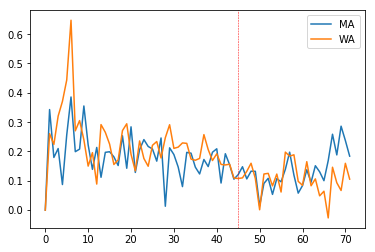

In [44]:
def plot_sentiment():
    krange=range(len(hr2cnt))
    plt.plot(krange, MA_sentiment, label='MA')
    plt.plot(krange, WA_sentiment, label='WA')
    # draw a vertical line indicating the start of the game
    plt.axvline(x=45, color='red', linestyle='--', linewidth=0.5)
    plt.legend(loc='best')
    plt.show()
    
plot_sentiment()